In the following example, you will try to predict the vote of people during an election in the United Kingdom by knowing some information on their knowledge and political orientation.

## 0. Importing Libraries

In [240]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn import metrics
from sklearn.metrics import f1_score, make_scorer
from sklearn.tree import plot_tree
import bisect

import warnings
warnings.filterwarnings('ignore')

##  1. Reading data

In [241]:
df = pd.read_csv("BEPS.csv")

In [242]:
df.head()

,vote,age,economic.cond.national,economic.cond.household,Blair,Hague,Kennedy,Europe,political.knowledge,gender
0,Liberal Democrat,43,3,3,4,1,4,2,2,female
1,Labour,36,4,4,4,4,4,5,2,male
2,Labour,35,4,4,5,2,3,3,2,male
3,Labour,24,4,2,2,1,3,4,0,female
4,Labour,41,2,2,1,1,4,6,2,male


In [243]:
df.shape

(1525, 10)

In [244]:
df.describe()

,age,economic.cond.national,economic.cond.household,Blair,Hague,Kennedy,Europe,political.knowledge
count,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000
mean,54.182295,3.245902,3.140328,3.334426,2.746885,3.135082,6.728525,1.542295
std,15.711209,0.880969,0.929951,1.174824,1.230703,1.081997,3.297538,1.083315
min,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,41.000000,3.000000,3.000000,2.000000,2.000000,2.000000,4.000000,0.000000
50%,53.000000,3.000000,3.000000,4.000000,2.000000,3.000000,6.000000,2.000000
75%,67.000000,4.000000,4.000000,4.000000,4.000000,4.000000,10.000000,2.000000
max,93.000000,5.000000,5.000000,5.000000,5.000000,5.000000,11.000000,3.000000


## 2. Exploratory Data Analysis

### 2.1. Missing Values

Check if the dataset contain any missing values.

In [245]:
missing_values_total = df.isnull().sum()
missing_values_total

vote                       0
age                        0
economic.cond.national     0
economic.cond.household    0
Blair                      0
Hague                      0
Kennedy                    0
Europe                     0
political.knowledge        0
gender                     0
dtype: int64

### 2.2. Distribution of the target variable

Plot the distribution of the target variable.

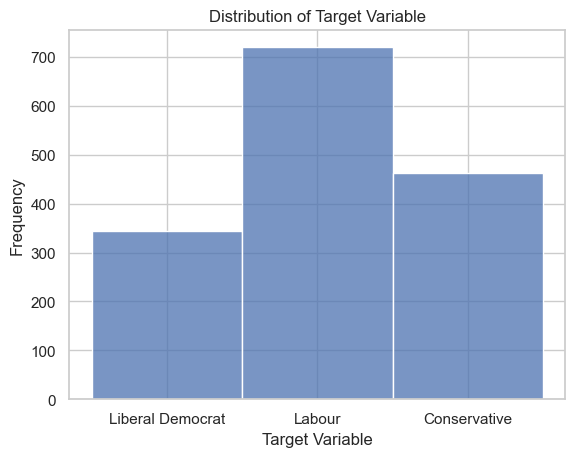

In [246]:
sns.histplot(df['vote'])  
plt.title('Distribution of Target Variable')
plt.xlabel('Target Variable')
plt.ylabel('Frequency')
plt.show()

### 2.3. Distribution of numerical variables

Plot the distribution of the numerical features.

In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1525 entries, 0 to 1524
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   vote                     1525 non-null   object
 1   age                      1525 non-null   int64 
 2   economic.cond.national   1525 non-null   int64 
 3   economic.cond.household  1525 non-null   int64 
 4   Blair                    1525 non-null   int64 
 5   Hague                    1525 non-null   int64 
 6   Kennedy                  1525 non-null   int64 
 7   Europe                   1525 non-null   int64 
 8   political.knowledge      1525 non-null   int64 
 9   gender                   1525 non-null   object
dtypes: int64(8), object(2)
memory usage: 119.3+ KB


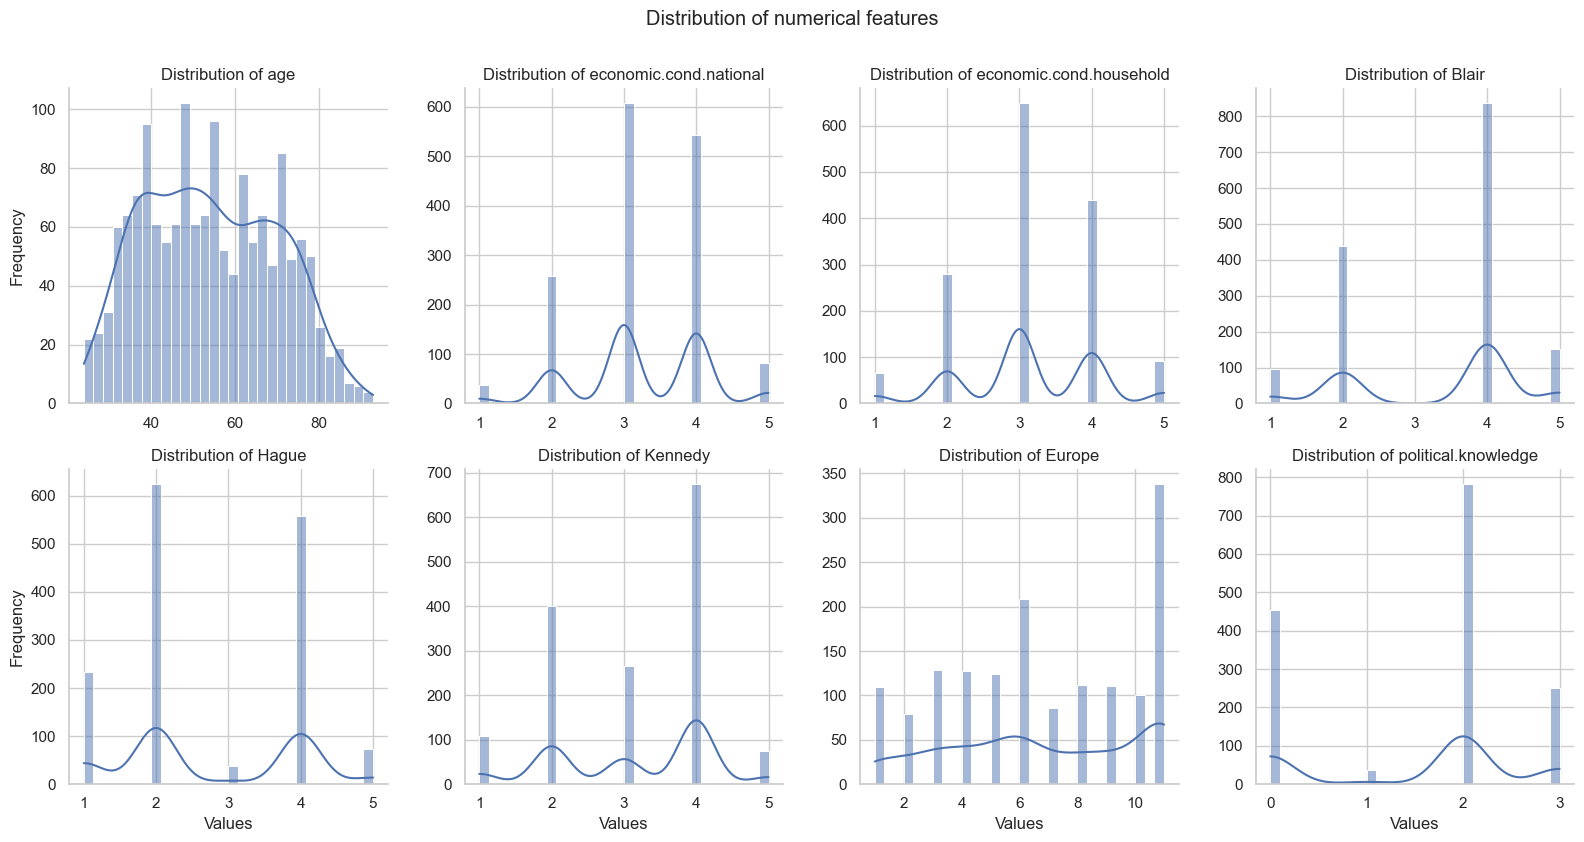

In [248]:
numerical_data = df.select_dtypes(include=np.number)

# Set the style of seaborn for better aesthetics
sns.set(style="whitegrid")

# Create a multi-grid plot for each numerical feature
grid = sns.FacetGrid(pd.melt(numerical_data), col="variable", col_wrap=4, sharex=False, sharey=False, height=4)
grid.map(sns.histplot, "value", bins=30, kde=True)
grid.set_titles("Distribution of {col_name}")
grid.set_axis_labels("Values", "Frequency")
plt.suptitle('Distribution of numerical features', y=1.05)
plt.show()

### 2.4. Histogram of catagorical variables

Plot the histogram of the catagorical features.

In [249]:
# A Dataframe include only non numerical features
categorical_data = df.select_dtypes(exclude=np.number)
categorical_data

,vote,gender
0,Liberal Democrat,female
1,Labour,male
2,Labour,male
3,Labour,female
4,Labour,male
...,...,...
1520,Conservative,male
1521,Conservative,male
1522,Labour,male
1523,Conservative,male


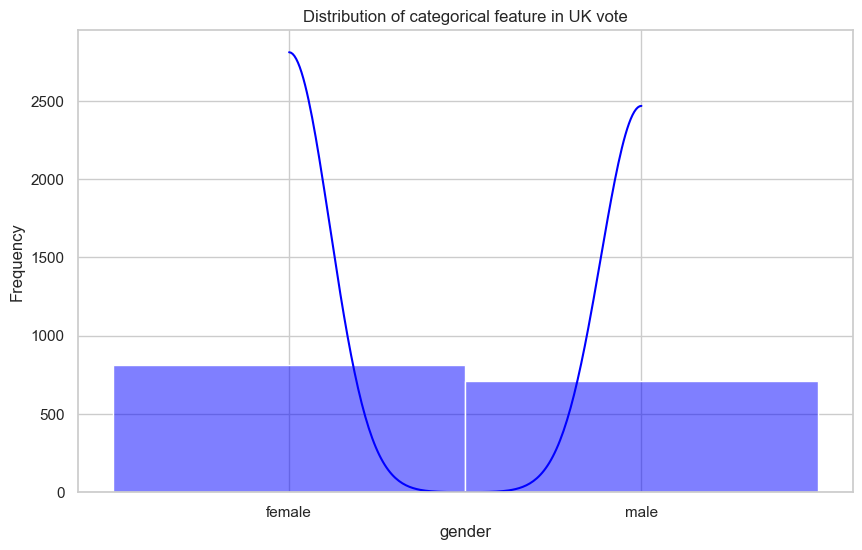

In [250]:
plt.figure(figsize=(10, 6))
sns.histplot(df['gender'], kde=True, color='blue', bins=50)
plt.title('Distribution of categorical feature in UK vote')
plt.xlabel('gender')
plt.ylabel('Frequency')
plt.show()


## 3. Data Splitting

Split the dataset into 2 training and test datasets.

In [251]:
# Define characteristics (X) and target variable (y)
X = df.drop('vote', axis=1)
y = df['vote']

# Divide data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now, X_train and y_train are your training sets, and X_test and y_test are your test sets.


## 4. Feature Engineering

### 4.1. Scaling numerical variables

In [252]:
numerical_columns = X_train.select_dtypes(include=np.number).columns

scaler = StandardScaler()

# Scale the features for the training set
X_train_scaled = scaler.fit_transform(X_train[numerical_columns])
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_columns, index=X_train.index)

# Scale the features for the test set
X_test_scaled = scaler.transform(X_test[numerical_columns])
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_columns, index=X_test.index)

# Drop original columns and replace them with scaled columns
X_train = X_train.drop(columns=numerical_columns)
X_train = pd.concat([X_train, X_train_scaled_df], axis=1)

X_test = X_test.drop(columns=numerical_columns)
X_test = pd.concat([X_test, X_test_scaled_df], axis=1)


In [253]:
X_train.head()

,gender,age,economic.cond.national,economic.cond.household,Blair,Hague,Kennedy,Europe,political.knowledge
1296,male,0.107799,0.863113,-0.146019,0.571642,-0.607803,0.806238,-0.231590,-1.398366
196,female,-0.018597,-0.270362,1.987439,-1.137679,1.009471,-1.025439,1.289077,0.431132
1146,male,-0.840171,0.863113,-0.146019,0.571642,-0.607803,-1.025439,-0.231590,0.431132
1349,female,1.118967,-0.270362,-1.212749,-1.137679,1.009471,-0.109600,0.072543,0.431132
81,female,-0.713775,-1.403837,0.920710,-1.137679,1.009471,-1.025439,-0.535724,-1.398366


### 4.2. Catagorical variables encoding

Convert catagorical columns into numerical columns using label encoding or one hot encoding.

In [254]:
# For One-Hot Encoding
X_train = pd.get_dummies(X_train, columns=['gender'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['gender'], drop_first=True)

In [255]:
X_train.head()

,age,economic.cond.national,economic.cond.household,Blair,Hague,Kennedy,Europe,political.knowledge,gender_male
1296,0.107799,0.863113,-0.146019,0.571642,-0.607803,0.806238,-0.231590,-1.398366,1
196,-0.018597,-0.270362,1.987439,-1.137679,1.009471,-1.025439,1.289077,0.431132,0
1146,-0.840171,0.863113,-0.146019,0.571642,-0.607803,-1.025439,-0.231590,0.431132,1
1349,1.118967,-0.270362,-1.212749,-1.137679,1.009471,-0.109600,0.072543,0.431132,0
81,-0.713775,-1.403837,0.920710,-1.137679,1.009471,-1.025439,-0.535724,-1.398366,0


## 5. Logistic Regression

Fit a logistic regression model on the training set. Evaluate the model on the testing set. Use the F1score as an evaluation metric.

In [256]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

# Print the F1 scores
print(f'F1 Micro: {f1_micro}')
print(f'F1 Macro: {f1_macro}')
print(f'F1 Weighted: {f1_weighted}')

F1 Micro: 0.6426229508196721
F1 Macro: 0.5764885078610568
F1 Weighted: 0.6133374893259174


## 6. Decision Tree

Fit a decision tree model on the training set. Use cross-validation in order to tune the hyperparameters of the decision tree model. Evaluate the model on the testing set. Use the Macro F1score as an evaluation metric.

In [257]:
dt_model = DecisionTreeClassifier(random_state=42)

# Define a parameter grid to search through
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use cross-validated grid search to find the best hyperparameters
macro_f1_scorer = make_scorer(f1_score, average='macro')
grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring=macro_f1_scorer)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Fit the model with the best hyperparameters on the entire training set
best_dt_model = grid_search.best_estimator_
best_dt_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = best_dt_model.predict(X_test)

# Calculate Macro F1 score on the testing set
macro_f1_test = f1_score(y_test, y_pred, average='macro')

# Display the best hyperparameters and Macro F1 score on the testing set
print(f'Best Hyperparameters: {best_params}')
print(f'Macro F1 Score on Testing Set: {macro_f1_test}')

Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Macro F1 Score on Testing Set: 0.49547623584039546


Plot the decision tree.

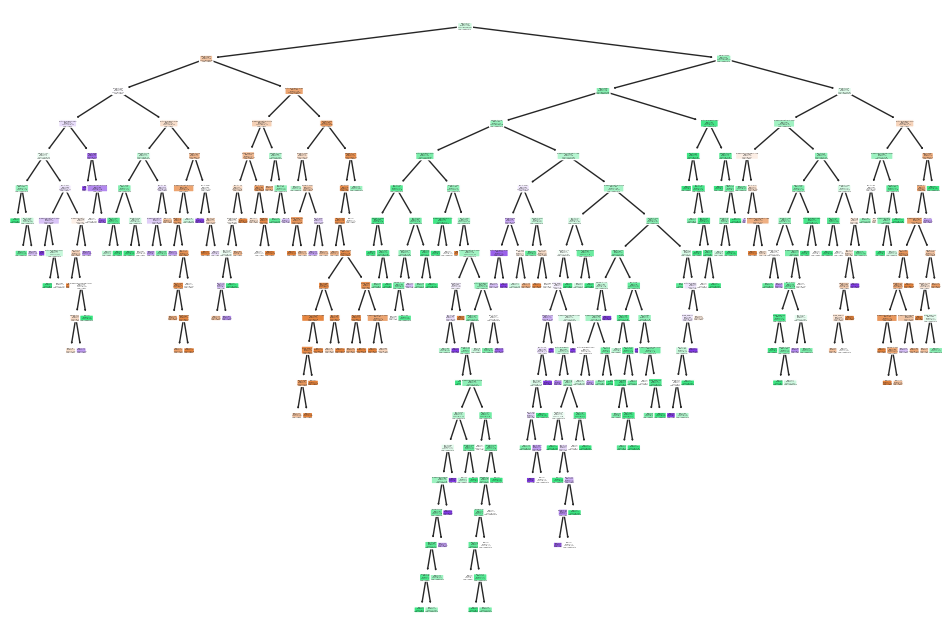

In [258]:
plt.figure(figsize=(12, 8))
plot_tree(best_dt_model, feature_names=X_train.columns.tolist(), class_names=y_train.tolist(), filled=True, rounded=True)
plt.show()

## 7. Random Forest

Fit a random forest model on the training set. Use cross-validation in order to tune the hyperparameters of the random forest model. Evaluate the model on the testing set. Use the Macro F1score as an evaluation metric.

In [259]:
rf_model = RandomForestClassifier(random_state=42)

# Define a parameter distribution to sample from
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Use randomized search to find the best hyperparameters
macro_f1_scorer = make_scorer(f1_score, average='macro')
randomized_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=10, cv=5, scoring=macro_f1_scorer, random_state=42)
randomized_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = randomized_search.best_params_

# Fit the model with the best hyperparameters on the entire training set
best_rf_model = randomized_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = best_rf_model.predict(X_test)

# Calculate Macro F1 score on the testing set
macro_f1_test = f1_score(y_test, y_pred, average='macro')

# Display the best hyperparameters and Macro F1 score on the testing set
print(f'Best Hyperparameters: {best_params}')
print(f'Macro F1 Score on Testing Set: {macro_f1_test}')

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}
Macro F1 Score on Testing Set: 0.5709641299805234


Plot feature importance/weight.

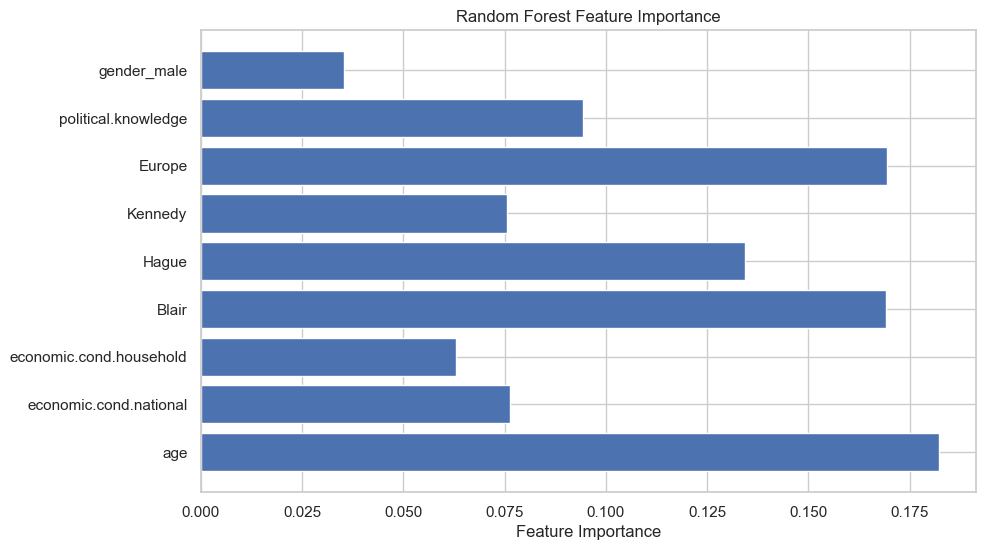

In [260]:
feature_importance = best_rf_model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

## 8. Gradient Boosting

Fit a gradient boosting model on the training set. Use cross-validation in order to tune the hyperparameters of the gradient boosting model. Evaluate the model on the testing set. Use the Macro F1score as an evaluation metric.

In [261]:
gb_model = GradientBoostingClassifier(random_state=42)

param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

macro_f1_scorer = make_scorer(f1_score, average='macro')
randomized_search = RandomizedSearchCV(gb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring=macro_f1_scorer, random_state=42)
randomized_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = randomized_search.best_params_

# Fit the model with the best hyperparameters on the entire training set
best_gb_model = randomized_search.best_estimator_
best_gb_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = best_gb_model.predict(X_test)

# Calculate Macro F1 score on the testing set
macro_f1_test = f1_score(y_test, y_pred, average='macro')

# Display the best hyperparameters and Macro F1 score on the testing set
print(f'Best Hyperparameters: {best_params}')
print(f'Macro F1 Score on Testing Set: {macro_f1_test}')

Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 7, 'learning_rate': 0.1}
Macro F1 Score on Testing Set: 0.5910068689599736


Plot feature importance/weight.

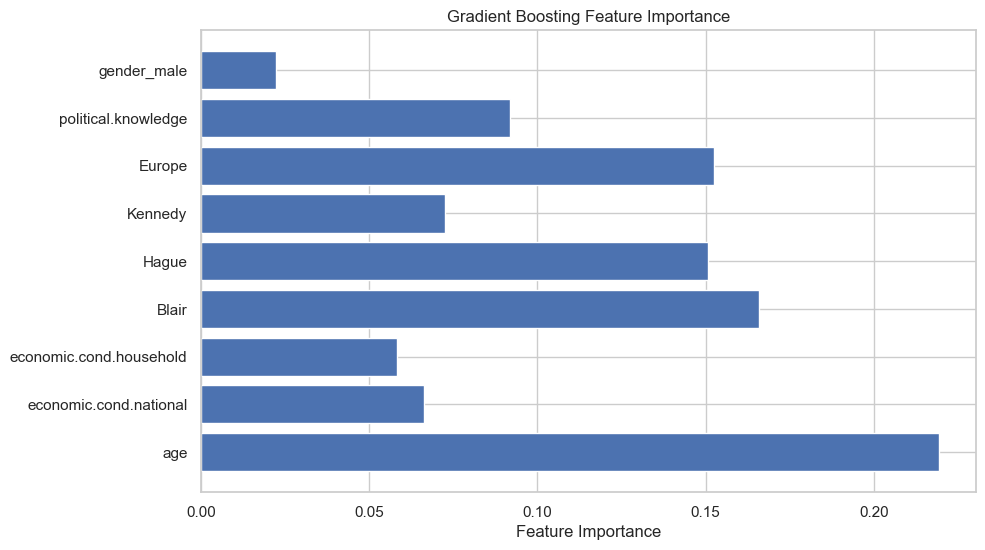

In [262]:
feature_importance = best_gb_model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Gradient Boosting Feature Importance')
plt.show()